In [1]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import os
import Bio.SeqIO as seq
import numpy as np
import matplotlib.pyplot as plt

scriptpath = "../../src/"
sys.path.append(os.path.abspath(scriptpath))
from KmerGroups import get_coverage

In [2]:
# Regions included in the metaprofile
bedRegs = pbt.BedTool('../../results/Metaprofiles/UTR3_termini/AllRegionsInMetaprofile.bed.gz').sort()
dfRegs = bedRegs.to_dataframe()
# Naive regions
dfNaive = pd.read_csv('../../results/Metaprofiles/UTR3_termini_naive/AllNaiveRegions.bed.gz', sep='\t', header=None)
with open('../../results/AnalyzeNaiveGenes/included_genes.txt', 'r') as f:
    relevantNaive = f.read().strip('\n').split('\n')
regsNaive = dfNaive.loc[dfNaive[6].isin(relevantNaive), [0, 1, 2, 6, 4, 5]]
bedNaive = pbt.BedTool.from_dataframe(regsNaive).sort()


# Genome
fasta = '../../data/genomes/Goodwright_m39/GRCm39.primary_assembly.genome.fa'

# K-mer groups
kmerGroups = pd.read_csv('../../results/20220906_ClusterKmers/FlatKmerClusters_Normalscale.tsv', sep='\t', index_col=0)

# Save to
outpath = '../../results/Metaprofiles/UTR3_termini/plots/'
os.makedirs(outpath, exist_ok=True)

# Get k-mer groups
uuuu = kmerGroups.loc[kmerGroups.consensus == 'UUUU'].index.tolist()
ugau = kmerGroups.loc[kmerGroups.consensus == 'UGAU'].index.tolist()
aggg = kmerGroups.loc[kmerGroups.consensus.isin(['AGGG', 'UGGG'])].index.tolist()
for el in [uuuu, ugau, aggg]:
    print(len(el))

nbins = 25

55
14
24


In [3]:
bedRegs.head()

chr1	4843433	4843934	CONTROL	-0.221081262692311	-	ENSMUSG00000033845
 chr1	4967631	4968132	DOWN	-1.70947008676754	+	ENSMUSG00000033813
 chr1	9617179	9617680	DOWN	-1.1207029482573	+	ENSMUSG00000061024
 chr1	10206492	10206993	CONTROL	-0.109735532097311	+	ENSMUSG00000056763
 chr1	12930915	12931416	DOWN	-2.00258175677654	+	ENSMUSG00000016918
 chr1	13634921	13635422	CONTROL	0.255102213174919	-	ENSMUSG00000025935
 chr1	14823569	14824070	DOWN	-2.02544522719183	-	ENSMUSG00000025930
 chr1	15913775	15914276	DOWN	-0.920995300646371	+	ENSMUSG00000025925
 chr1	16712990	16713491	DOWN	-2.03541018996949	-	ENSMUSG00000079658
 chr1	16747998	16748499	DOWN	-1.31737189386335	+	ENSMUSG00000025940
 

In [4]:
def convertDictToList(d):
    return [d[i] for i in sorted([int(v) for v in d.keys()])]

def comp_coverage(l):
    return sum(l) * 100 / len(l)

In [5]:
dfRegs.groupby('name').count()['chrom']

name
CONTROL    1760
DOWN        768
UP          623
Name: chrom, dtype: int64

In [6]:
heatmaps = {}
for id, bt in dict(zip(['fullGroups', 'naive'],[bedRegs, bedNaive])).items():
    # Extract sequences
    bt.sequence(fi=fasta, s=True, name=True, fo=f'{outpath}/{id}_Sequences.fasta')
    # Parse sequences to df
    array = []
    with open(f'{outpath}/{id}_Sequences.fasta') as handle:
        for record in seq.parse(handle, "fasta"):
            array.append([record.id, str(record.seq).replace('T', 'U')])
    dfSequences = pd.DataFrame(array, columns=['id', 'sequence'])
    print(dfSequences.head())
    dfSequences['name'] = dfSequences.id.apply(lambda x: x.split('::')[0])

    # Get coverage for k-mer groups across the entire sequence
    dfSequences['UUUU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=uuuu, kmer_length=5))
    dfSequences['GGGA-GGGU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=aggg, kmer_length=5))
    dfSequences['UGAU'] = dfSequences.sequence.apply(lambda x: get_coverage(x, kmer_group=ugau, kmer_length=5))

    #Put coverages in list form
    dfSequences['UUUU'] = dfSequences['UUUU'].apply(lambda x: convertDictToList(x))
    dfSequences['GGGA-GGGU'] = dfSequences['GGGA-GGGU'].apply(lambda x: convertDictToList(x))
    dfSequences['UGAU'] = dfSequences['UGAU'].apply(lambda x: convertDictToList(x))
    print(dfSequences.head())
    # Split regions into differentially regulated groups
    if id == 'fullGroups':
        dfSequencesDown = dfSequences.loc[dfSequences.name == 'DOWN'].reset_index(drop=True)
        dfSequencesOther = dfSequences.loc[dfSequences.name != 'DOWN'].reset_index(drop=True)
        dfDict = {'DOWN': dfSequencesDown, 'CONTROL+UP': dfSequencesOther}
    else:
        dfDict = {'naive': dfSequences}

    # Organize into heatmap form
    cols = ['UUUU', 'GGGA-GGGU', 'UGAU']
    heatmapDict = {}
    for c in cols:
        dfheatmap = pd.DataFrame()
        for k, v in dfDict.items():
            array = np.array(v[c].values.tolist())
            if len(array) > 0:
                split_array = np.array_split(array, nbins, axis=1)
                binCoverages = []
                for a in split_array:
                    coverage = np.apply_along_axis(comp_coverage, 1, a)
                    binCoverages.append(coverage.mean())
                dfheatmap[k] = binCoverages
        heatmapDict[c] = dfheatmap
    heatmaps[id] = heatmapDict

                                   id  \
0    CONTROL::chr1:4843433-4843934(-)   
1       DOWN::chr1:4967631-4968132(+)   
2       DOWN::chr1:9617179-9617680(+)   
3  CONTROL::chr1:10206492-10206993(+)   
4     DOWN::chr1:12930915-12931416(+)   

                                            sequence  
0  AUCACCAGCCCACAGAUGGCACCACCCACAAUGGGCUGGGUCCUUC...  
1  UUCACAUCGUCUUCCUGACACAGAUGUUGUAAUGCAUAUAGUAAAG...  
2  AAUUAUAUCUACCUGUGAUUUGCAAGUAUUGUAAAUGGAUGCAGGU...  
3  AUGAUGAUACGUUAUGUAUAUAUAAUGUACAUAAAAGCCCUGAUUA...  
4  UAUUCUUGAGCUCACCCUGUUUCUGUUGGACUUUUAGAGACCAGUC...  
                                   id  \
0    CONTROL::chr1:4843433-4843934(-)   
1       DOWN::chr1:4967631-4968132(+)   
2       DOWN::chr1:9617179-9617680(+)   
3  CONTROL::chr1:10206492-10206993(+)   
4     DOWN::chr1:12930915-12931416(+)   

                                            sequence     name  \
0  AUCACCAGCCCACAGAUGGCACCACCCACAAUGGGCUGGGUCCUUC...  CONTROL   
1  UUCACAUCGUCUUCCUGACACAGAUGUUGUAAUGCAUAUAGUA

In [7]:
heatmaps

{'fullGroups': {'UUUU':          DOWN  CONTROL+UP
  0   21.924603   18.566033
  1   24.309896   20.228703
  2   22.636719   21.479228
  3   23.645833   21.265212
  4   24.726562   21.674360
  5   23.619792   21.443559
  6   24.980469   21.137222
  7   24.466146   21.246328
  8   24.817708   21.674360
  9   24.108073   21.859001
  10  26.477865   21.479228
  11  24.069010   21.907260
  12  26.041667   22.016366
  13  24.759115   22.219891
  14  26.197917   21.890474
  15  27.226562   22.356274
  16  26.171875   23.409568
  17  27.682292   22.874528
  18  29.075521   24.714645
  19  31.822917   25.297944
  20  32.792969   26.544272
  21  37.233073   28.036089
  22  41.178385   31.804448
  23  35.501302   30.874948
  24  35.351562   30.000000,
  'GGGA-GGGU':          DOWN  CONTROL+UP
  0    8.959573   10.273165
  1    9.674479   10.755350
  2   10.605469   11.023919
  3   11.106771   10.514058
  4   10.058594   10.809903
  5   10.091146   11.047000
  6   11.328125   10.841376
  7   10.384

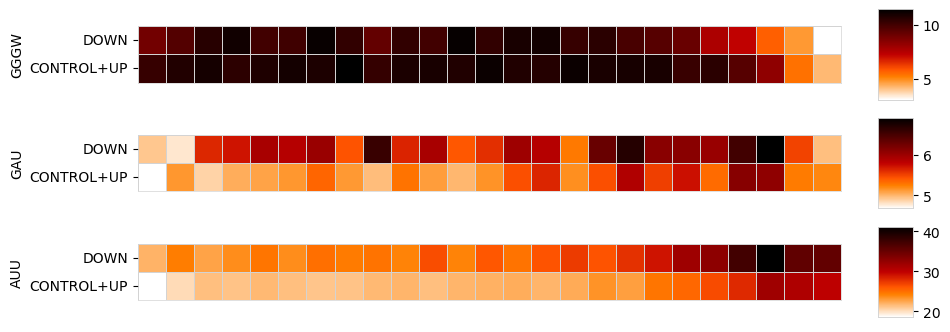

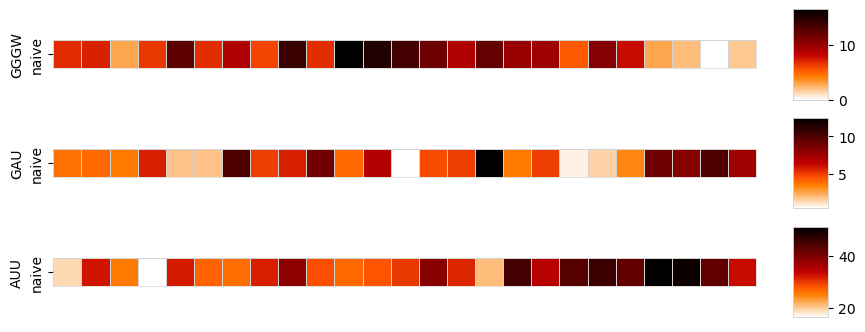

In [8]:
for id, heatmapDict in heatmaps.items():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,4), gridspec_kw={'width_ratios':[10, 0.5], 'wspace':0.1})
    sns.heatmap(heatmapDict['GGGA-GGGU'].T, square=True, cmap='gist_heat_r', ax=axs[0, 0], xticklabels=False, cbar_ax=axs[0, 1], linewidths=.5, linecolor='lightgrey')
    axs[0, 0].set_ylabel('GGGW')
    sns.heatmap(heatmapDict['UGAU'].T, square=True, cmap='gist_heat_r', ax=axs[1, 0], xticklabels=False, cbar_ax=axs[1, 1], linewidths=.5, linecolor='lightgrey')
    axs[1, 0].set_ylabel('GAU')
    sns.heatmap(heatmapDict['UUUU'].T, square=True, cmap='gist_heat_r', ax=axs[2, 0], xticklabels=False, cbar_ax=axs[2, 1], linewidths=.5, linecolor='lightgrey')
    axs[2, 0].set_ylabel('AUU')

    for ax in axs.ravel():
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(.5)
            spine.set_color('lightgrey')

    if id == 'fullGroups':
        fig.savefig(f'{outpath}/geneGroups_motifCoverage_heatmap_cellLimits.pdf', bbox_inches='tight')
    else:
        for ax in axs.ravel()[::2]:
            ax.set_yticklabels(['naive'])
        fig.savefig(f'{outpath}/naiveGenes_motifCoverage_heatmap_cellLimits.pdf', bbox_inches='tight')